导入库，检查GPU可用性

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

下载数据集

In [ ]:
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MNIST = True

# 获取训练集dataset
training_data = torchvision.datasets.MNIST(
    root='./data/',  # dataset存储路径
    train=True,  # True表示是train训练集，False表示test测试集
    transform=torchvision.transforms.ToTensor(),  # 将原数据规范化到（0,1）区间
    download=DOWNLOAD_MNIST,
)

60000张图片，28*28

In [4]:
print(training_data.data.size())
print(training_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


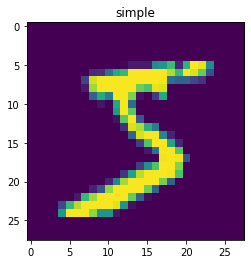

In [7]:
plt.imshow(training_data.data[0])
plt.title('simple')
plt.show()

In [9]:
# 通过torchvision.datasets获取的dataset格式可直接可置于DataLoader
train_loader = Data.DataLoader(dataset=training_data, batch_size=BATCH_SIZE,
                               shuffle=True)

# 获取测试集dataset
test_data = torchvision.datasets.MNIST(root='./data/', train=False)
# 取前2000个测试集样本

test_x = Variable(torch.unsqueeze(test_data.data, dim=1),
                  volatile=True).type(torch.FloatTensor)[:2000].cuda()
# (2000, 28, 28) to (2000, 1, 28, 28), in range(0,1)
test_y = test_data.targets[:2000].cuda()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # (1,28,28)
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5,
                      stride=1, padding=2),  # (16,28,28)
            # 想要con2d卷积出来的图片尺寸没有变化, padding=(kernel_size-1)/2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # (16,14,14)
        )
        self.conv2 = nn.Sequential(  # (16,14,14)
            nn.Conv2d(16, 32, 5, 1, 2),  # (32,14,14)
            nn.ReLU(),
            nn.MaxPool2d(2)  # (32,7,7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 将（batch，32,7,7）展平为（batch，32*7*7）
        output = self.out(x)
        return output

Epoch: 0 |Step: 0 |train loss:2.3147 |test accuracy:0.1975
Epoch: 0 |Step: 100 |train loss:0.2703 |test accuracy:0.8965
Epoch: 0 |Step: 200 |train loss:0.1937 |test accuracy:0.9365
Epoch: 0 |Step: 300 |train loss:0.1504 |test accuracy:0.9500
Epoch: 0 |Step: 400 |train loss:0.0810 |test accuracy:0.9570
Epoch: 0 |Step: 500 |train loss:0.0758 |test accuracy:0.9605
Epoch: 0 |Step: 600 |train loss:0.0312 |test accuracy:0.9675
Epoch: 0 |Step: 700 |train loss:0.0428 |test accuracy:0.9690
Epoch: 0 |Step: 800 |train loss:0.0255 |test accuracy:0.9730
Epoch: 0 |Step: 900 |train loss:0.2094 |test accuracy:0.9650
Epoch: 0 |Step: 1000 |train loss:0.0624 |test accuracy:0.9760
Epoch: 0 |Step: 1100 |train loss:0.0237 |test accuracy:0.9750
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0') prediction number
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], device='cuda:0') real number


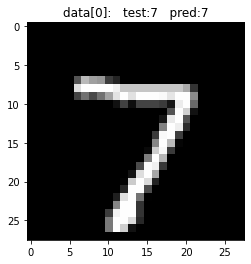

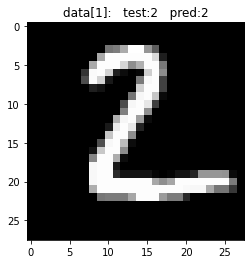

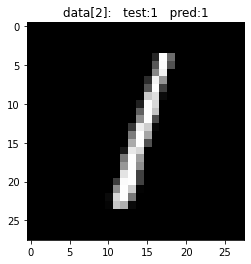

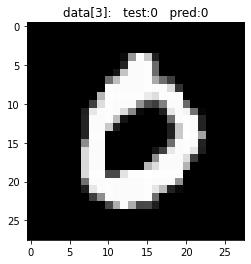

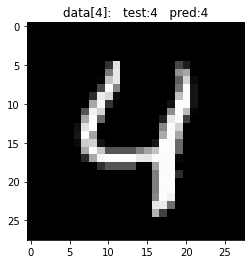

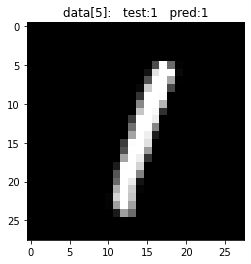

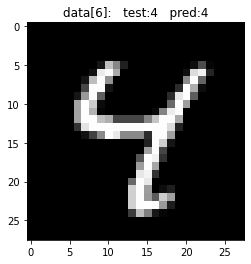

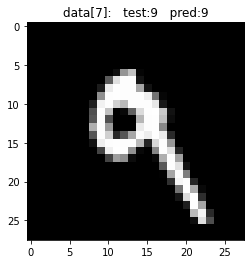

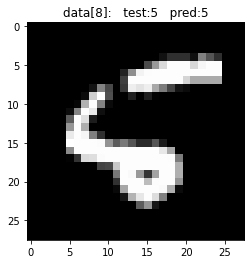

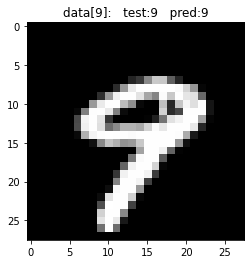

In [11]:
cnn = CNN()
cnn.cuda()

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_function = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x).cuda()
        b_y = Variable(y).cuda()

        output = cnn(b_x)
        loss = loss_function(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
            s1=sum(pred_y == test_y)
            s2=test_y.size(0)
            accuracy = s1/(s2*1.0)
            print('Epoch:', epoch, '|Step:', step,
                  '|train loss:%.4f' % loss.item(), '|test accuracy:%.4f' % accuracy)

test_output = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].cuda().data.squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

for n in range(10):
    plt.imshow(test_data.data[n].numpy(), cmap='gray')
    plt.title('data[%i' % n+']:   test:%i' % test_data.targets[n]+'   pred:%i' % pred_y[n])
    plt.show()